# Part 2: Data labeling
Collaboration with Rita Lyu.

Now that all the training data have been labeled, we want to extract meaning full features from what we have to train classifiers that provide adequate accuracy to label all 193,000 tweets in our original dataset. For each class, we will test out different algorithms suitable for the data natures.   



**Table of Contents**
1. [Extracting the features](#sec1)
2. [Determining user type](#sec2)
3. [Period tracker relevance](#sec3)
4. [Sentiment Analysis](#sec4)
5. [Labeling the data](#sec5)
    

 ### 1. Extracting the features

In [1]:
import pandas as pd
import numpy as np
import csv, json
import warnings
warnings.filterwarnings('ignore')

In [2]:
tweets = pd.read_csv('training_tweets.csv')
tweets.head()

,tweet_id,time,user_id,text,retweet_count,reply_count,like_count,quote_count,username,name,...,verified,followers_count,tweet_count,tweets_SRH,following_count,user_type,listed_count,period_tracking,data_concern,sentiment
0,1511835211692077058,2022-04-06 22:36:17+00:00,1.329283e+18,@Margare19954289 I was shocked to discover how...,0,0,1,0,LeslieG03751183,Leslie GG/ Cheeky Oma ☮️💖🙀🤭🤢🙄😷💚🇺🇦🙏🏻🇺🇦,...,False,183,3868.0,1,129,indv,0.0,False,False,negative
1,1501587893264998401,2022-03-09 15:57:06+00:00,1.308420e+18,Me: cannot figure out why my skin is going nut...,0,1,1,0,ModelAyshaMirza,Aysha 💋 Did you cheat? #ProtectWomen 💕🇺🇸🧬🥇,...,False,1159,32699.0,2,1688,indv,6.0,True,False,neutral
2,1548449627577282560,2022-07-16 23:28:54+00:00,2.194982e+09,@CBCNews Since Covid vaccines first became ava...,0,0,0,0,HaolinS,TSH,...,False,4,16803.0,26,54,org,0.0,False,False,negative
3,1539564861797142528,2022-06-22 11:04:01+00:00,3.637561e+08,@darji8114 @Gonzz70998539 Du sollst es dir nur...,0,0,4,0,Vanillekind,DieDrei!!!,...,False,217,3591.0,4,372,indv,11.0,False,False,neutral
4,1530811214053658624,2022-05-29 07:20:09+00:00,4.260665e+07,महिलाओं के पीरियड्स को लेकर IAS अफसर ने चलाया ...,9,0,122,0,aajtak,AajTak,...,True,18921459,727621.0,4,43,org,5108.0,False,False,neutral


Here are the list of features we would like to determine:  

Rita:  

    1. Tweet frequency (tweets/week)
    2. Followers/following ratio
    3. Bio length, has emoji, has “organization, org, news, agency, institution”, vs “personal, I, my,”
    4. Length of tweet text
    
Lan:        

    5. Popularity: likes/followers, retweet/followers, replies/followers         
    6. Tweet has url
    7. Tweet has emoji
    8. Number of exclamation mark in tweet content
    9. Number of quotation mark in tweet content
    10. Name has emoji
    11. Listed count/followers
    
Along with preexisting features from the dataset:   

    12. Tweet sentiment    
    13. Frequency of tweets SRH
    14. Verified status
    15. Tweet reach: likes, replies, retweets count

    

Functions to extract the features

In [3]:
#count tweets/week ratio

def tweet_frequency(start, end, tweet_count):
   
    #convert datatime series to nano-second
    start = pd.to_datetime(start).to_datetime64()
    end = pd.to_datetime(end).to_datetime64()
    x = (end - start)
    
    #calculate the number of week
    wk_num = np.ceil(x.astype(float) / (7*86400*1e9))
   
    #count divide number of weeks
    return round(tweet_count/wk_num,2)

#find if emoji is in text

def has_emoji(text):
    emoji_summary = adv.extract_emoji(str(text))
    emoji_counts = emoji_summary['emoji_counts']
    if (1 in emoji_counts):
        return True
    else:
        return False
    
    
#if text contains “organization, org, news, agency, institution”

def contains_org_key(text):
    if any(word in str(text).lower() for word in ['organization', 'org', 'news', 'agency', 'institution']):
        return True
    return False


#if text contains “organization, org, news, agency”

def contains_indv_key(text):
    if any(word in str(text).lower() for word in ['personal', 'i', 'my']):
        return True
    return False        

#if text contains url
has_URL = lambda x: True if 'https:' in str(x) else False

#number of exclaimation mark ("no way?!?" would have 3)
num_exc = lambda x: sum(str(x).lower().count(c) for c in ['!', '?','@'])

#number of quotation marks (assuming news would quote at a higher frequency)
num_quote = lambda x: sum(str(x).lower().count(c) for c in ['"']) 

length = lambda x: len(str(x))

#ratio
def log_ratio(a,b):
    if b == 0:
        return 0
    ratio = np.divide(a, b)
    if ratio == 0:
        return 0
    return np.log2(ratio)
    

In [4]:
df = tweets

Let's transform our training dataset

In [5]:
#1. Tweet frequency (tweets/week)
df['tweet_freq']= df.apply(lambda x: tweet_frequency(x['created_at_y'], '2022-10-25', x['tweet_count']),axis=1)

#2. followers/followings ratio
df['followers/followings'] = df.apply(lambda x: log_ratio(x['followers_count'], x['following_count']), axis=1)
# round(df['followers_count']/df['following_count']*1000,2)

#3. Bio length, has emoji, has “organization, org, news, agency, institution”, vs “personal, i, my,”
df['bio_len'] = df['description'].apply(length)
# df['bio_has_emoji'] = df['description'].apply(has_emoji)
df['bio_has_org'] = df['description'].apply(contains_org_key)
df['bio_has_ind'] = df['description'].apply(contains_indv_key)

4#. Tweet text length:
df['tweet_len'] = df['text'].apply(length)

#5. Popularity: likes/followers, retweet/followers, replies/followers   
df['like/followers'] = df.apply(lambda x: log_ratio(x['like_count'], x['followers_count']), axis=1)
df['rt/followers'] = df.apply(lambda x: log_ratio(x['retweet_count'], x['followers_count']), axis=1)
df['rp/followers'] = df.apply(lambda x: log_ratio(x['reply_count'], x['followers_count']), axis=1)

#6. Tweet has url
df['tweet_has_url'] = df['text'].apply(has_URL)

#7. Tweet has emoji
# df['tweet_has_emoji'] = df['text'].apply(has_emoji)

#8. Number of exclamation mark in tweet content
df['num_exc'] = df['text'].apply(num_exc)

#9. Number of quotation mark in tweet content
df['num_qm'] = df['text'].apply(num_quote)

#10. Name has emoji
# df['name_has_emoji'] = df['name'].apply(has_emoji)

#11. Listed count/followers
df['listed/followers'] = df.apply(lambda x: log_ratio(x['listed_count'], x['followers_count']), axis=1)

#12. Convert everything to 1 and 0
df['verified'] = df['verified'].replace(True, 1)
df['verified'] = df['verified'].replace(False, 0)

One final step at replacing indetermined values with 0

In [6]:
df.replace([np.inf, -np.inf], 0, inplace=True)
df.replace(np.nan, 0)
df.head()

,tweet_id,time,user_id,text,retweet_count,reply_count,like_count,quote_count,username,name,...,bio_has_org,bio_has_ind,tweet_len,like/followers,rt/followers,rp/followers,tweet_has_url,num_exc,num_qm,listed/followers
0,1511835211692077058,2022-04-06 22:36:17+00:00,1.329283e+18,@Margare19954289 I was shocked to discover how...,0,0,1,0,LeslieG03751183,Leslie GG/ Cheeky Oma ☮️💖🙀🤭🤢🙄😷💚🇺🇦🙏🏻🇺🇦,...,False,True,268,-7.515700,0.000000,0.000000,False,1,0,0.000000
1,1501587893264998401,2022-03-09 15:57:06+00:00,1.308420e+18,Me: cannot figure out why my skin is going nut...,0,1,1,0,ModelAyshaMirza,Aysha 💋 Did you cheat? #ProtectWomen 💕🇺🇸🧬🥇,...,False,True,151,-10.178665,0.000000,-10.178665,False,1,0,-7.593702
2,1548449627577282560,2022-07-16 23:28:54+00:00,2.194982e+09,@CBCNews Since Covid vaccines first became ava...,0,0,0,0,HaolinS,TSH,...,False,False,196,0.000000,0.000000,0.000000,True,1,0,0.000000
3,1539564861797142528,2022-06-22 11:04:01+00:00,3.637561e+08,@darji8114 @Gonzz70998539 Du sollst es dir nur...,0,0,4,0,Vanillekind,DieDrei!!!,...,False,True,154,-5.761551,0.000000,0.000000,False,2,0,-4.302120
4,1530811214053658624,2022-05-29 07:20:09+00:00,4.260665e+07,महिलाओं के पीरियड्स को लेकर IAS अफसर ने चलाया ...,9,0,122,0,aajtak,AajTak,...,True,True,87,-17.242783,-21.003595,0.000000,True,0,0,-11.854977


### 2. Determining user type

We will be testing out these classifiers with the features we extracted 

    1. Linear SVC
    2. K-nn 
    3. Random forest, and Linear SVC 

But first, let's check for imbalance between the different classes

In [7]:
orgs = df.loc[tweets['user_type']=='org']
indvs = df.loc[tweets['user_type']=='indv']
bot = df.loc[tweets['user_type']=='bot']
print(f"Number of accounts that belong to organizations is: {orgs.shape}")
print(f"Number of accounts that belong to individuals is: {indvs.shape}")
print(f"Number of accounts that belong to bots is: {bot.shape}")

Number of accounts that belong to organizations is: (417, 35)
Number of accounts that belong to individuals is: (2554, 35)
Number of accounts that belong to bots is: (28, 35)


There's a clear imbalance in between the classes. To address this imbalance, we will oversample the minority class that is "orgs" and undersample majority class that is "indvs". The proportion of bot is insignicant, so we will assump that it is not accounted in the datset and sample 300 rows from each class. 

In [8]:
import random

random.seed(625814)

o_index = list(orgs.index)
i_index = list(indvs.index)

Helper function for randomly partitioning the training dataset:

In [9]:

# def get_indices(x, y):
indices_org_train = random.sample(o_index, 300)
indices_indv_train = random.sample(i_index, 300)

indices_org_test = [index for index in o_index  if index not in indices_org_train]
indices_indv_test = [index for index in i_index if index not in indices_indv_train]


indices_org_train.extend(indices_indv_train) #indices for training
indices_org_test.extend(indices_indv_test) #indices for testing
print(len(indices_org_train))


600


Extracting desired features:

In [10]:
data = df[['user_type','retweet_count', 'reply_count',
       'like_count', 'quote_count', 'verified', 'followers_count', 'tweets_SRH', 
        'following_count', 'listed_count', 'tweet_freq', 
       'followers/followings', 'bio_len', 
       'bio_has_org','bio_has_ind', 'tweet_len', 'like/followers', 'rt/followers',
       'rp/followers', 'tweet_has_url', 
        'num_exc', 'num_qm', 'listed/followers']].reset_index(drop = 'True')

Separating the features and labels

In [11]:
features = data.iloc[:,1:]
labels = data['user_type']

One hot encoding

In [12]:
import sklearn
from sklearn.feature_extraction import DictVectorizer

vec = DictVectorizer(sparse = False, dtype = float)
x = vec.fit_transform(features.to_dict('record'))
dfVectors = pd.DataFrame(x, columns = vec.get_feature_names())

Getting our training and testing dataset

In [13]:
X_train = dfVectors.iloc[indices_org_train].fillna(0)
y_train = labels.iloc[indices_org_train]

X_test = dfVectors.iloc[indices_org_test].fillna(0)
y_test = labels.iloc[indices_org_test]

Now we are ready to train our classifiers

#### a. Linear SVC

In [14]:
from sklearn import svm
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
import matplotlib.pyplot as plt

Testing out Linear SVC

In [15]:
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)


# Training a SVM classifier using SVC class
sdg = SGDClassifier(loss="log", penalty="l2")
sdg.fit(X_train_std, y_train)
 
# Mode performance
 
y_pred = sdg.predict(X_test_std)
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

Accuracy: 0.739


Improving the classifier using Grid search

In [16]:
from sklearn.model_selection import GridSearchCV

In [17]:
params = {
    "loss" : ["hinge", "log", "squared_hinge", "modified_huber", "perceptron"],
    "alpha" : [0.0001, 0.001, 0.01, 0.1],
    "penalty" : ["l2", "l1", "elasticnet", "none"],
}

sdg = SGDClassifier(max_iter=1000)
grid = GridSearchCV(sdg, param_grid=params, cv=10)


grid.fit(X_train_std, y_train)

print(grid.best_params_) 

{'alpha': 0.1, 'loss': 'log', 'penalty': 'l2'}


Refitting our model with the new parameters

In [18]:
grid_predictions = grid.predict(X_test_std) 

print('Accuracy: {:.2f}'.format(accuracy_score(y_test, grid_predictions)))


Accuracy: 0.76


In [19]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt


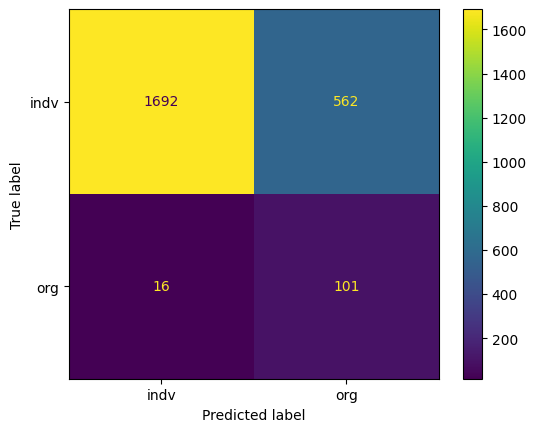

In [20]:
plot_confusion_matrix(grid, X_test_std, y_test)  
plt.show()

The classifier is classifying a lot of individual account as orgs

#### b. Using k-nn

In [21]:
from sklearn import neighbors
knn = neighbors.KNeighborsClassifier() 
knn

KNeighborsClassifier()

In [22]:
knn.fit(X_train, y_train) 
knn.score(X_test, y_test) 

0.6824124841838887

Grid search for k-nn

In [23]:
grid_params = {'n_neighbors': [3, 5, 7, 9, 11, 13, 15],    
               'weights': ['uniform', 'distance'], 
               'metric': ['euclidean', 'cosine']
              }

In [24]:
from sklearn.model_selection import GridSearchCV

gs = GridSearchCV(
    neighbors.KNeighborsClassifier(),
    grid_params,
    verbose=1,         # print output while working 
    cv=3               # number of folds for cross-validation 
)

In [25]:
gs_results = gs.fit(X_train, y_train)

Fitting 3 folds for each of 28 candidates, totalling 84 fits


In [26]:
gs_results.best_score_

0.695

In [27]:
gs_results.best_estimator_

KNeighborsClassifier(metric='cosine', n_neighbors=7, weights='distance')

In [28]:
gs_results.best_params_

{'metric': 'cosine', 'n_neighbors': 7, 'weights': 'distance'}

Let's see where the algorithm is making the mistake

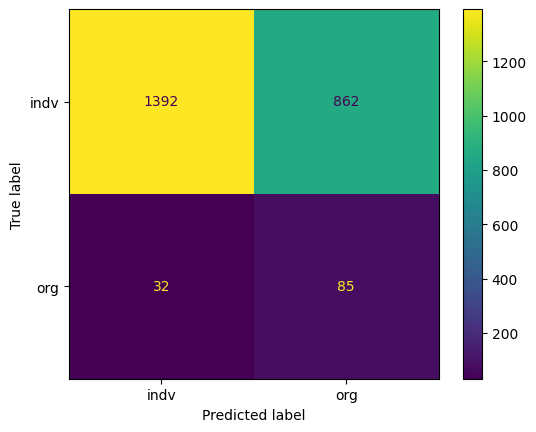

In [29]:
plot_confusion_matrix(gs_results, X_test, y_test)  
plt.show()

We see the same problem happen here

#### c. Random Forest

In [30]:
from sklearn.ensemble import RandomForestClassifier

In [31]:
rf =RandomForestClassifier(n_estimators=100)
rf

RandomForestClassifier()

In [32]:
rf.fit(X_train, y_train)
rf.score(X_test, y_test) 

0.7692956558414171

Let's take the top 20 important features:

In [33]:
rf_params = {'n_estimators': [100, 200],
             'max_features': ['auto', 'sqrt'],
             'max_depth': [10, 50],
             'min_samples_split': [2, 20]}

cv=[(slice(None), slice(None))]

rf_clf = GridSearchCV(RandomForestClassifier(random_state=24),rf_params, n_jobs=-1, verbose=2, cv=cv)
rf_clf.fit(X_train, y_train)

#best parameters of model
print(rf_clf.best_params_)

#make predictions
rf_pred = rf_clf.predict(X_test)
print('Accuracy', accuracy_score(rf_pred, y_test))

Fitting 1 folds for each of 16 candidates, totalling 16 fits
{'max_depth': 50, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 100}
Accuracy 0.774778574441164


Where is the classifier making mistake?

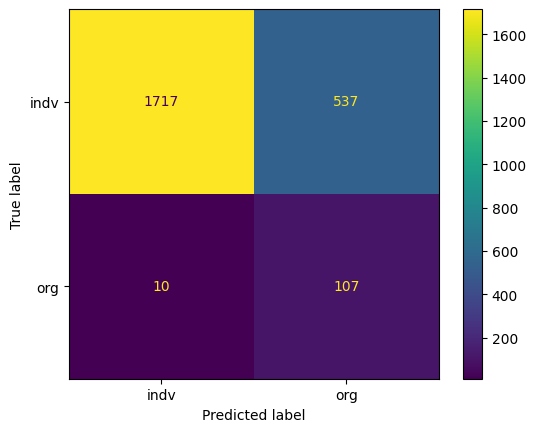

In [34]:
plot_confusion_matrix(rf, X_test, y_test)  
plt.show()

#### d. Choosing the best classifier and fine tuning

Random forest performed the best out of all the classifiers. Furthermore, we observed that in all confusion matrices, the algorithm is giving too much weight to orgs, so this algorithm is fitting for making an imbalanced training dataset that reflects the real distribution of orgs vs indvs.

Let's make a new training dataset with some imbalance, keeping the orgs:indv ratio at 1:2, 1:3, 1:4, 1:5

In [35]:
rf = RandomForestClassifier(n_estimators=100)

random.seed(625814)
o_index = list(orgs.index)
i_index = list(indvs.index)

Let's test out these parameters

In [36]:
def tuning(ratio):
    indices_org_train = random.sample(o_index,300)
    indices_indv_train = random.sample(i_index, ratio)
    indices_org_test = [index for index in o_index  if index not in indices_org_train]
    indices_indv_test = [index for index in i_index if index not in indices_indv_train]   
    indices_org_train.extend(indices_indv_train)
    indices_org_test.extend(indices_indv_test)
    X_train = dfVectors.iloc[indices_org_train].fillna(0)
    y_train = labels.iloc[indices_org_train]
    X_test = dfVectors.iloc[indices_org_test].fillna(0)
    y_test = labels.iloc[indices_org_test]
    rf.fit(X_train, y_train)
    print(f'new score for {ratio} is {rf.score(X_test, y_test)}')
    return rf

In [37]:
indv = [600, 900, 1200, 1500]
for i in indv:
    tuning(i)

new score for 600 is 0.8672139063254466
new score for 900 is 0.9141727837380011
new score for 1200 is 0.9095853161114887
new score for 1500 is 0.9017933390264731


The 1:4 ratio gives us the best accuracy

In [38]:
rf = tuning(1200)

new score for 1200 is 0.9143439836845684


Let's check the confusion matrix

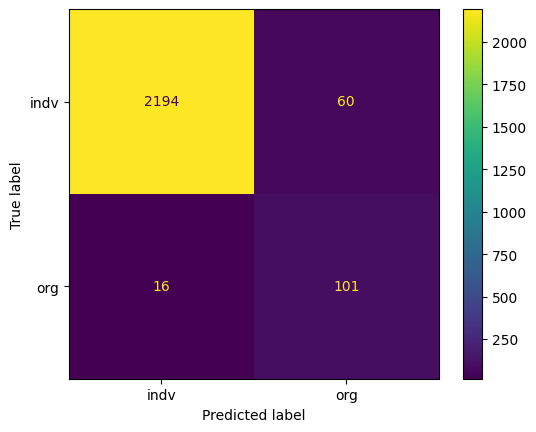

In [39]:
plot_confusion_matrix(rf, X_test, y_test)  
plt.show()

The classifier is making a lot less mistake now after it was fed more information about individual accounts

Let's examining what features are determined to be the most important and if trimmming it would increase our accuracy

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


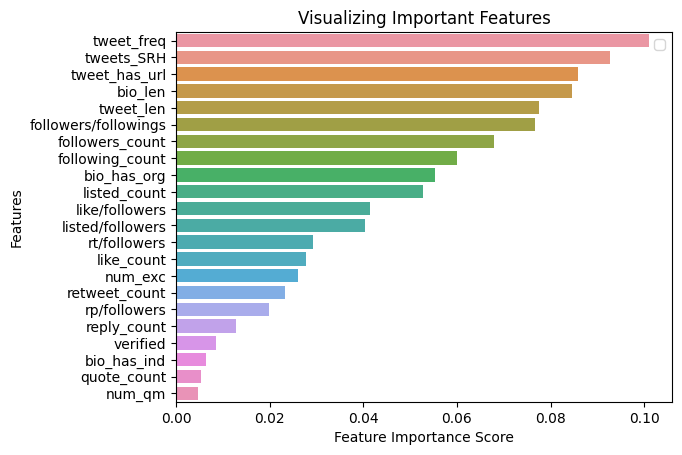

In [40]:
import seaborn as sns
%matplotlib inline
feature_imp = pd.Series(rf.feature_importances_,index=X_train.columns).sort_values(ascending=False)
feature_imp
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

In [41]:
for x in [10,15,20,25]:
    keep_features = list(feature_imp.index[:x])
    X_train_new = X_train[keep_features]
    X_test_new = X_test[keep_features]
    rf = RandomForestClassifier(n_estimators=100)
    rf.fit(X_train_new, y_train)
    print(f'new score for keeping top {x} features is {rf.score(X_test_new, y_test)}')

new score for keeping top 10 features is 0.7739350485027414
new score for keeping top 15 features is 0.7553774778574441
new score for keeping top 20 features is 0.7676086039645719
new score for keeping top 25 features is 0.7739350485027414


We see no improvement, so there is no need for pruning the trees. In conclusion, random forest is the best performing classifier for user type at the 1:4 ratio

In [42]:
rf_best = tuning(1200)

new score for 1200 is 0.9150237933378654


In [43]:
X_train.columns

Index(['bio_has_ind', 'bio_has_org', 'bio_len', 'followers/followings',
       'followers_count', 'following_count', 'like/followers', 'like_count',
       'listed/followers', 'listed_count', 'num_exc', 'num_qm', 'quote_count',
       'reply_count', 'retweet_count', 'rp/followers', 'rt/followers',
       'tweet_freq', 'tweet_has_url', 'tweet_len', 'tweets_SRH', 'verified'],
      dtype='object')

### 3. Period tracker relevancy

For this classifier, we've decided to use  Naive Bayes text classification with the tweet content 

In [44]:
from sklearn.feature_extraction.text import CountVectorizer

In [45]:
text = df[['period_tracking', 'text']]

t_features = text['text'].fillna('')
t_labels = text['period_tracking']

vectorizer = CountVectorizer()
t_X = vectorizer.fit_transform(t_features)

t_X_train = vectorizer.fit_transform(t_features.iloc[indices_org_train])
t_y_train = t_labels.iloc[indices_org_train]

t_X_test = vectorizer.transform(t_features.iloc[indices_org_test])
t_y_test = t_labels.iloc[indices_org_test]

In [46]:
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB()
print(classifier)

MultinomialNB()


In [47]:
clf = MultinomialNB()
clf.fit(t_X_train, t_y_train)

MultinomialNB()

In [48]:
y_pred_class = clf.predict(t_X_test)
accuracy_score(t_y_test, y_pred_class)

0.9169126950653732

This is a good score! We won't need any tuning with this

### 4. Sentiment Analysis

For this task, we first decided to use the roBerta classifier since it's especially fine tuned for tweet sentiment analysis. However, the model takes extreme computational process and with no times permitting, we've decided to use Naive Bayes for this task again. 

In [49]:
import numpy as np
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer


def replace_usernames(tweet, special_token='<USERNAME>'):
  return re.sub('@[\w]+', special_token, tweet)

def replace_urls(tweet, special_token='<URL>'):
  return re.sub(r'https?://[\n\S]+\b', special_token, tweet)

from emot.emo_unicode import UNICODE_EMOJI, EMOTICONS_EMO
# translate emoji
def emoji(text):
  for emot in UNICODE_EMOJI:
    if text == None:
      text = text
    else:
      text = text.replace(emot, "_".join(UNICODE_EMOJI[emot].replace(",", "").replace(":", "").split()))
    return text

# remove non ascii character
def non_ascii(s):
  return "".join(i for i in s if ord(i)<128)

def punct(text):
  token=RegexpTokenizer(r'\w+')#regex
  text = token.tokenize(text)
  text= " ".join(text)
  return text 

def removeStopWords(str):
#select english stopwords
  cachedStopWords = set(stopwords.words("english"))
#add custom words
  cachedStopWords.update(('and','I','A','http','And','So','arnt','This','When','It','many','Many','so','cant','Yes','yes','No','no','These','these','mailto','regards','ayanna','like','email'))
#remove stop words
  new_str = ' '.join([word for word in str.split() if word not in cachedStopWords]) 
  return new_str


def remove_(tweet):
  tweet = re.sub('([_]+)', "", tweet)
  return tweet

def process_tweets(tweet):
  tweet = str(tweet).lower()
  tweet = remove_(tweet)
  tweet = punct(tweet)
  tweet = non_ascii(tweet)
  tweet = emoji(tweet)
  tweet = removeStopWords(tweet)
  return replace_usernames(replace_urls(tweet))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dauho\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [50]:
sen = tweets[['sentiment','text']]
sen['clean_text'] = sen['text'].apply(process_tweets)
sen_features = sen['clean_text'].fillna('')
sen_labels = sen['sentiment']

In [51]:
pos = tweets.loc[tweets['sentiment']=='positive']
neg = tweets.loc[tweets['sentiment']=='negative']
neu = tweets.loc[tweets['sentiment']=='neutral']

In [52]:
print(pos.shape)
print(neg.shape)
print(neu.shape)

(292, 35)
(1013, 35)
(1695, 35)


Choosing different ratio of sampling

In [53]:
random.seed(625814)

pos_index = list(pos.index)
neg_index = list(neg.index)
neu_index = list(neu.index)


indices_pos_train = random.sample(pos_index, 200)
indices_neg_train = random.sample(neg_index, 600)
indices_neu_train = random.sample(neu_index, 900)
    
    
indices_pos_test = [index for index in pos_index if index not in indices_pos_train]
indices_neg_test = [index for index in neg_index if index not in indices_neg_train]
indices_neu_test = [index for index in neu_index if index not in indices_neu_train]

In [54]:
indices_pos_train.extend(indices_neg_train)
indices_pos_train.extend(indices_neu_train)
indices_pos_test.extend(indices_neg_test)
indices_pos_test.extend(indices_neu_test)

In [55]:
vectorizer = CountVectorizer()

X_train = vectorizer.fit_transform(sen_features.iloc[indices_pos_train])
y_train = sen_labels.iloc[indices_pos_train]

X_test = vectorizer.transform(t_features.iloc[indices_pos_test])
y_test = sen_labels.iloc[indices_pos_test]

classifier = MultinomialNB()
classifier.fit(X_train, y_train)

y_pred_class = classifier.predict(X_test)
accuracy_score(y_test, y_pred_class)

0.6138461538461538

Naive Bayes struggles to label the tweets' sentiment due to its complex nature. For this task, I've decided to use the roBerta model since it's been fine tuned specifically for tweets sentiment analysis, which will be done on a separate Colab notebook.

### 5. Labeling our data

Now that we've determined the best classifiers for our data:

1. Random Forest for User type
2. Naive Bayes for period tracker relevancy

**We can finally label our dataset**

In [56]:
dfr = pd.read_csv("data.csv", index_col=0)
dfr.shape

(193204, 18)

In [57]:
dfr.columns

Index(['id', 'created_at_x', 'user_id', 'text', 'retweet_count', 'reply_count',
       'like_count', 'quote_count', 'username', 'name', 'description',
       'created_at_y', 'verified', 'followers_count', 'following_count',
       'tweet_count', 'listed_count', 'tweets_SRH'],
      dtype='object')

In [58]:
# data = dfr.loc[dfr['created_at_x']>'2022-02-25']
# data.shape

In [59]:
#1. Tweet frequency (tweets/week)
dfr['tweet_freq']= dfr.apply(lambda x: tweet_frequency(x['created_at_y'], '2022-10-25', x['tweet_count']),axis=1)

#2. followers/followings ratio
dfr['followers/followings'] = dfr.apply(lambda x: log_ratio(x['followers_count'], x['following_count']), axis=1)
# round(df['followers_count']/df['following_count']*1000,2)

#3. Bio length, has emoji, has “organization, org, news, agency, institution”, vs “personal, i, my,”
dfr['bio_len'] = dfr['description'].apply(length)
# df['bio_has_emoji'] = df['description'].apply(has_emoji)
dfr['bio_has_org'] = dfr['description'].apply(contains_org_key)
dfr['bio_has_ind'] = dfr['description'].apply(contains_indv_key)

4#. Tweet text length:
dfr['tweet_len'] = dfr['text'].apply(length)

#5. Popularity: likes/followers, retweet/followers, replies/followers   
dfr['like/followers'] = dfr.apply(lambda x: log_ratio(x['like_count'], x['followers_count']), axis=1)
dfr['rt/followers'] = dfr.apply(lambda x: log_ratio(x['retweet_count'], x['followers_count']), axis=1)
dfr['rp/followers'] = dfr.apply(lambda x: log_ratio(x['reply_count'], x['followers_count']), axis=1)

#6. Tweet has url
dfr['tweet_has_url'] = dfr['text'].apply(has_URL)

#7. Tweet has emoji
# df['tweet_has_emoji'] = df['text'].apply(has_emoji)

#8. Number of exclamation mark in tweet content
dfr['num_exc'] = dfr['text'].apply(num_exc)

#9. Number of quotation mark in tweet content
dfr['num_qm'] = dfr['text'].apply(num_quote)

#10. Name has emoji
# df['name_has_emoji'] = df['name'].apply(has_emoji)

#11. Listed count/followers
dfr['listed/followers'] = dfr.apply(lambda x: log_ratio(x['listed_count'], x['followers_count']), axis=1)

#12. Convert everything to 1 and 0
dfr['verified'] = dfr['verified'].replace(True, 1)
dfr['verified'] = dfr['verified'].replace(False, 0)

**Labeling user type**

In [60]:
df_pred_user = dfr[['retweet_count', 'reply_count',
       'like_count', 'quote_count', 'verified', 'followers_count', 'tweets_SRH', 
        'following_count', 'listed_count', 'tweet_freq', 'followers/followings', 'bio_len', 
       'bio_has_org','bio_has_ind', 'tweet_len', 'like/followers', 'rt/followers',
       'rp/followers', 'tweet_has_url', 
        'num_exc', 'num_qm', 'listed/followers']].reset_index(drop = True)

In [61]:
features_pred = df_pred_user.replace([np.inf, -np.inf], 0, inplace=True)
features_pred = df_pred_user.replace(np.nan, 0)


vec = DictVectorizer(sparse = False, dtype = float)
x = vec.fit_transform(features_pred.to_dict('record'))
dfVectors = pd.DataFrame(x, columns = vec.get_feature_names())
X_user = dfVectors.fillna(0)

In [62]:
dfr['user_type'] = rf_best.predict(X_user)

In [63]:
dfr.head()

,id,created_at_x,user_id,text,retweet_count,reply_count,like_count,quote_count,username,name,...,bio_has_ind,tweet_len,like/followers,rt/followers,rp/followers,tweet_has_url,num_exc,num_qm,listed/followers,user_type
0,1448802667292200966,2021-10-15 00:07:27+00:00,521716695,I wonder how long before women are not allowed...,0,0,1,0,_sconsolato,Dewi ♀,...,True,188,-9.471675,0.0,0.000000,True,1,0,-9.471675,indv
1,1464783777381683206,2021-11-28 02:30:41+00:00,521716695,I've been watching these mid-century education...,0,0,0,0,_sconsolato,Dewi ♀,...,True,158,0.000000,0.0,0.000000,True,1,0,-9.471675,indv
2,1501648630725369859,2022-03-09 19:58:27+00:00,521716695,@dan_nailed @PurveyorOfPest1 @mjeslfc @BioTran...,0,1,3,0,_sconsolato,Dewi ♀,...,True,347,-7.886713,0.0,-9.471675,False,6,0,-9.471675,indv
3,1448803736076365824,2021-10-15 00:11:42+00:00,595644055,"@Draconacticus @HamillHimself When we say ""per...",0,1,0,0,JordansMom769,Cindy H,...,False,221,0.000000,0.0,-4.087463,False,2,2,0.000000,indv
4,1448804546059268098,2021-10-15 00:14:55+00:00,1154281865441767424,"“Menstruation is when you have a kid, right?”",0,0,0,0,_queenoffools,N8🕸,...,True,45,0.000000,0.0,0.000000,False,1,0,0.000000,indv


**Labeling period tracker relevance**

In [64]:
df_txt = dfr[['text']]

In [65]:
text_features = df_txt['text'].fillna('')
text_features

0         I wonder how long before women are not allowed...
1         I've been watching these mid-century education...
2         @dan_nailed @PurveyorOfPest1 @mjeslfc @BioTran...
3         @Draconacticus @HamillHimself When we say "per...
4             “Menstruation is when you have a kid, right?”
                                ...                        
195870    @LightShiner2 @FK_Mystel @VincentFletcher @Pan...
195871    Façon dont la femme aime le sexe que pour leur...
195872    1/ "Access to menstrual hygiene products and i...
195873    why is my period tracker so fucking funny http...
195874    @DivineIndulgnce Did you try to change it on p...
Name: text, Length: 193204, dtype: object

In [66]:
vectorizer = CountVectorizer()

t_X_train = vectorizer.fit_transform(t_features.iloc[indices_org_train])
t_y_train = t_labels.iloc[indices_org_train]


clf = MultinomialNB()
clf.fit(t_X_train, t_y_train)

X = vectorizer.transform(text_features)

dfr['period_tracker'] = clf.predict(X) 

In [67]:
dfr.head()

,id,created_at_x,user_id,text,retweet_count,reply_count,like_count,quote_count,username,name,...,tweet_len,like/followers,rt/followers,rp/followers,tweet_has_url,num_exc,num_qm,listed/followers,user_type,period_tracker
0,1448802667292200966,2021-10-15 00:07:27+00:00,521716695,I wonder how long before women are not allowed...,0,0,1,0,_sconsolato,Dewi ♀,...,188,-9.471675,0.0,0.000000,True,1,0,-9.471675,indv,False
1,1464783777381683206,2021-11-28 02:30:41+00:00,521716695,I've been watching these mid-century education...,0,0,0,0,_sconsolato,Dewi ♀,...,158,0.000000,0.0,0.000000,True,1,0,-9.471675,indv,False
2,1501648630725369859,2022-03-09 19:58:27+00:00,521716695,@dan_nailed @PurveyorOfPest1 @mjeslfc @BioTran...,0,1,3,0,_sconsolato,Dewi ♀,...,347,-7.886713,0.0,-9.471675,False,6,0,-9.471675,indv,False
3,1448803736076365824,2021-10-15 00:11:42+00:00,595644055,"@Draconacticus @HamillHimself When we say ""per...",0,1,0,0,JordansMom769,Cindy H,...,221,0.000000,0.0,-4.087463,False,2,2,0.000000,indv,False
4,1448804546059268098,2021-10-15 00:14:55+00:00,1154281865441767424,"“Menstruation is when you have a kid, right?”",0,0,0,0,_queenoffools,N8🕸,...,45,0.000000,0.0,0.000000,False,1,0,0.000000,indv,False


Since performing sentiment analysis is computationally intensive, it's best if we filter out the dataset for only data we want to study. Now we can export the data for sentiment analysis using the roBerta model

In [68]:
data = dfr.loc[(dfr['user_type']=='indv') & (dfr['period_tracker']== True)]
data['clean_text'] = data['text'].apply(process_tweets)
data.head()

,id,created_at_x,user_id,text,retweet_count,reply_count,like_count,quote_count,username,name,...,like/followers,rt/followers,rp/followers,tweet_has_url,num_exc,num_qm,listed/followers,user_type,period_tracker,clean_text
10,1448810682451955715,2021-10-15 00:39:18+00:00,131701372,Period tracker a blessing,0,0,0,0,NatashaMonique_,Natasha,...,0.000000,0.0,0.0,False,0,0,-4.877953,indv,True,period tracker blessing
122,1449071590499516419,2021-10-15 17:56:04+00:00,16673960,@Jordeevee @leilacohan Period Tracker,0,0,0,0,bansidhewail,Dana Goddard,...,0.000000,0.0,0.0,False,2,0,-6.554589,indv,True,jordeevee leilacohan period tracker
123,1450489091737284611,2021-10-19 15:48:42+00:00,16673960,@siacancu @leilacohan I just use Period Tracker.,0,0,0,0,bansidhewail,Dana Goddard,...,0.000000,0.0,0.0,False,2,0,-6.554589,indv,True,siacancu leilacohan use period tracker
136,1543696071137820674,2022-07-03 20:39:58+00:00,2338348428,What's #Best on https://t.co/flXwnOkooM ? The ...,0,0,3,2,FremontCyril,CYRIL FREMONT,...,-9.570488,0.0,0.0,True,1,0,0.000000,indv,True,best https co flxwnokoom post roe data privacy...
140,1543696163458764801,2022-07-03 20:40:20+00:00,2300501173,#Best of the day on https://t.co/k05yokndMa Th...,0,0,1,1,BestTLD,.Best Top-Level Domain,...,-11.700873,0.0,0.0,True,0,0,-5.818230,indv,True,best day https co k05yokndma post roe data pri...


**Labeling sentiment**

Let's export the dataset for sentiment analysis for the roBerta model from HuggingFace:

In [197]:
data.to_csv('partial_labeled_data.csv')

This is the end of part 2. 